In [ ]:
%%capture
!pip install python-graphblas


In [ ]:
!gdown 1zRLt0DWI5J_tb8q3AoNukjR2n1b_tvc6
!unzip graphs.zip
!rm -rf graphs.zip


Downloading...
From: https://drive.google.com/uc?id=1zRLt0DWI5J_tb8q3AoNukjR2n1b_tvc6
To: /content/graphs.zip
100% 531k/531k [00:00<00:00, 8.38MB/s]
Archive:  graphs.zip
   creating: graphs/
  inflating: graphs/EX4.mtx          
  inflating: __MACOSX/graphs/._EX4.mtx  
  inflating: graphs/data.mtx         
  inflating: __MACOSX/graphs/._data.mtx  
  inflating: graphs/G58.mtx          
  inflating: __MACOSX/graphs/._G58.mtx  
  inflating: graphs/G60.mtx          
  inflating: __MACOSX/graphs/._G60.mtx  
  inflating: graphs/Erdos982.mtx     
  inflating: __MACOSX/graphs/._Erdos982.mtx  
  inflating: graphs/delaunay_n13.mtx  
  inflating: __MACOSX/graphs/._delaunay_n13.mtx  
  inflating: graphs/G14.mtx          
  inflating: __MACOSX/graphs/._G14.mtx  
  inflating: graphs/G22.mtx          
  inflating: __MACOSX/graphs/._G22.mtx  
  inflating: graphs/G55.mtx          
  inflating: __MACOSX/graphs/._G55.mtx  
  inflating: graphs/G43.mtx          
  inflating: __MACOSX/graphs/._G43.mtx  


In [ ]:
import graphblas as gb

gb.init("suitesparse", blocking=False)

from graphblas import Matrix, dtypes, unary, binary, monoid, semiring, Recorder
from graphblas.io import mmread
import numpy as np

# Основная часть

In [ ]:
M = mmread('graphs/G14.mtx')
# M.setdiag(0)
M

"M_278"    nvals  nrows  ncols  dtype     format
gb.Matrix   9388    800    800   FP64  csr (iso)
------------------------------------------------
     0    1    2    3    4    5    6    7    8    9    ...  790  791 792 793  \
0         1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...                     
1    1.0       1.0  1.0                 1.0  1.0       ...                     
2    1.0  1.0       1.0  1.0       1.0  1.0       1.0  ...                     
3    1.0  1.0  1.0       1.0  1.0  1.0  1.0  1.0       ...  1.0                
4    1.0       1.0  1.0       1.0  1.0  1.0       1.0  ...       1.0           
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ..  ..   
795                                     1.0            ...                     
796                      1.0                           ...                     
797                                               1.0  ...                     
798                                                    ...                     
799                                1.0       1.0       ...                     

    794 795  796 797 798 799  
0                             
1                             
2                             
3                             
4            1.0              
..   ..  ..  ...  ..  ..  ..  
795                           
796                           
797                           
798                           
799

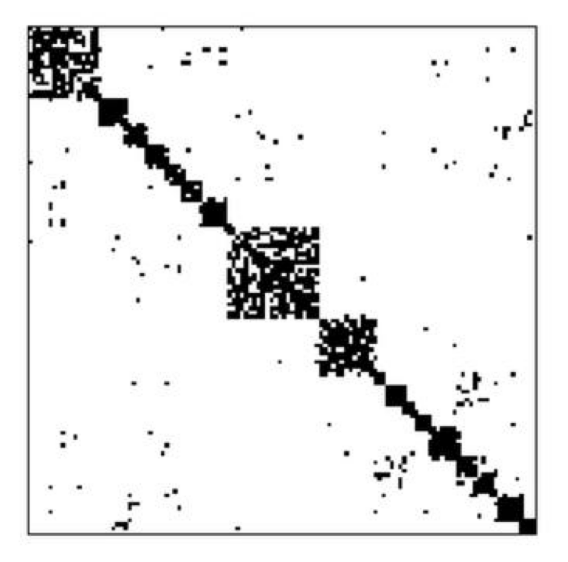

In [ ]:
print(M.dtype)
print(M.nrows)
print(M.ncols)
print(M.nvals)

FP64
800
800
9388


In [ ]:
def get_triag_number(A):
    tmp = gb.Matrix(A.dtype, A.nrows, A.ncols)
    tmp << A.mxm(A.mxm(A))
    traingle = tmp.diag().reduce(gb.agg.sum).value or 0
    return int(traingle) // 6

In [ ]:
get_triag_number(M)
# M.diag().reduce(gb.agg.sum).value or 0

5302

In [ ]:
def get_triag_number_mask(A):
    tmp = gb.Matrix(A.dtype, A.nrows, A.ncols)
    tmp(A.S) << A.mxm(A)
    return int(tmp.reduce_scalar(gb.agg.sum).value or 0) // 6

In [ ]:
get_triag_number_mask(M)

5302

In [ ]:
def get_triag_number_cohen(A):
  tmp_L = gb.Matrix(A.dtype, A.nrows, A.ncols)
  tmp_U = gb.Matrix(A.dtype, A.nrows, A.ncols)
  tmp = gb.Matrix(A.dtype, A.nrows, A.ncols)
  tmp_L << gb.select.tril(A)
  tmp_U << gb.select.triu(A)
  tmp(A.S) << tmp_L.mxm(tmp_U)
  return int(tmp.reduce_scalar(gb.agg.sum).value or 0) // 2

In [ ]:
get_triag_number_cohen(M)

5302

In [ ]:
def get_triag_number_sandia(A):
  tmp_L1 = gb.Matrix(A.dtype, A.nrows, A.ncols)
  tmp_L2 = gb.Matrix(A.dtype, A.nrows, A.ncols)
  tmp_L1 << gb.select.tril(A)
  tmp_L2(A.S) << tmp_L1.mxm(tmp_L1)
  return int(tmp_L2.reduce_scalar(gb.agg.sum).value or 0)

In [ ]:
get_triag_number_sandia(M)

5302

# Нахождение количества треугольников, в которых участвует данная вершина

In [ ]:
def get_triag_numbe_for_nodes(A):
    tmp = gb.Matrix(A.dtype, A.nrows, A.ncols)
    tmp << A.mxm(A.mxm(A))
    return tmp.diag() / 2

In [ ]:
get_triag_numbe_for_nodes(M)

gb.VectorExpression                        size  dtype
v_86.apply(binary.truediv[FP64], right=2)   800   FP64

"Result"   nvals  size  dtype
gb.Vector    800   800   FP64
-----------------------------
index    0     1      2      3      4      5      6      7      8      9    \
value  268.0  50.0  263.0  384.0  304.0  159.0  330.0  123.0  169.0  109.0   

index  ...  790  791  792  793  794  795  796  797  798  799  
value  ...  6.0  6.0  7.0  6.0  7.0  6.0  6.0  6.0  6.0  5.0  

Do expr.new() or other << expr to calculate the expression.

In [ ]:
def get_triag_numbe_for_nodes_mask(A):
    tmp = gb.Matrix(A.dtype, A.nrows, A.ncols)
    tmp(A.S) << A.mxm(A)
    return tmp.reduce_columnwise() / 2

In [ ]:
get_triag_numbe_for_nodes_mask(M)

gb.VectorExpression                         size  dtype
v_136.apply(binary.truediv[FP64], right=2)   800   FP64

"Result"   nvals  size  dtype
gb.Vector    800   800   FP64
-----------------------------
index    0     1      2      3      4      5      6      7      8      9    \
value  268.0  50.0  263.0  384.0  304.0  159.0  330.0  123.0  169.0  109.0   

index  ...  790  791  792  793  794  795  796  797  798  799  
value  ...  6.0  6.0  7.0  6.0  7.0  6.0  6.0  6.0  6.0  5.0  

Do expr.new() or other << expr to calculate the expression.